# NasNet

In [1]:
%tensorflow_version 1.x
!pip install tflearn

TensorFlow 1.x selected.


In [3]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten,Dropout,BatchNormalization,AveragePooling2D,concatenate,Input, concatenate
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge

#Load oxflower17 dataset
import tflearn.datasets.oxflower17 as oxflower17
from sklearn.model_selection import train_test_split
x, y = oxflower17.load_data(one_hot=True)

#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle = True)

#Data augumentation with Keras tools
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )


NUM_CLASSES = 17
FREEZE_LAYERS = 2

# 以訓練好的NASNetMobile為基礎來建立模型，捨棄ResNet50頂層的fully connected layers
net = NASNetMobile(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(224, 224, 3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
#print(net_final.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


19996672/19993432 [==============================] - 1s 0us/step


In [4]:
History = net_final.fit_generator(img_gen.flow(X_train*255, y_train, batch_size = 16),
                                      steps_per_epoch = len(X_train)/16, validation_data = (X_test,y_test), epochs = 2 )




Epoch 1/2
68/68 [==============================] - 116s 2s/step - loss: 4.1542 - accuracy: 0.0754 - val_loss: 3.0034 - val_accuracy: 0.1434
Epoch 2/2
68/68 [==============================] - 39s 581ms/step - loss: 2.9534 - accuracy: 0.2123 - val_loss: 2.6300 - val_accuracy: 0.2059


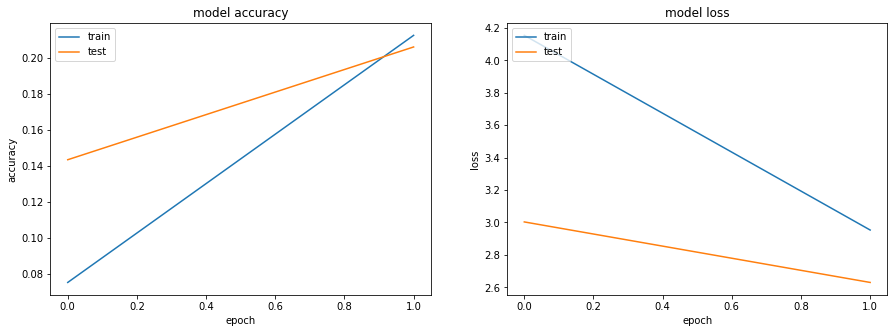

In [5]:
#Plot Loss and accuracy
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.show()